In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

In [2]:
gym.logger.set_level(40)

In [3]:
ENV_NAME = 'Pendulum-v0'
input_dim = 3
action_list = [4/10*i-2 for i in range(11)]
action_dim = len(action_list)

In [4]:
NUM_THREADS = 8

#T_max = 10000
MAX_EP = 200000
t_max = 100
print_freq = 500

beta = 0.01   # entropy regularization
gamma = 0.9
alpha = 0.99   # RMSProb decay factor
learning_rate = 1e-4
decay_rate = 0.999

class A3C_v2(nn.Module):
    def __init__(self, input_dim, action_dim, max_ep=0, is_global=False):
        super(A3C_v2, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.max_ep = max_ep
        
        self.distribution = torch.distributions.Categorical
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_dim)
        self.fc5 = nn.Linear(64, 1)
        
        self.ep_counter = None
        self.ep_returns = None
        self.average_returns = None
        
        if is_global:
            self.set_global()
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pi = self.fc4(x)
        prob = self.distribution(F.softmax(pi, dim=0))
        value = self.fc5(x)
        return pi, prob, value
    
    def set_global(self):
        self.ep_counter = mp.Value('i')
        self.ep_counter.value = 0
        self.ep_returns = mp.Array('d', self.max_ep)
        self.average_returns = mp.Array('d',self.max_ep)
        
    def log_episode(self, ep_return):
        c = self.ep_counter.value
        self.ep_returns[c] = ep_return
        self.average_returns[c] = np.mean(self.ep_returns[max(0, c-99):c+1])
        self.ep_counter.value += 1
        return self.ep_counter.value

In [5]:
class A3C_v3(nn.Module):
    def __init__(self, input_dim, action_dim, max_ep=0, is_global=False):
        super(A3C_v3, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.max_ep = max_ep
        
        self.distribution = torch.distributions.Categorical
        
        self.fc_pi1 = nn.Linear(input_dim, 128)
        self.fc_pi2 = nn.Linear(128, action_dim)
        self.fc_v1 = nn.Linear(input_dim, 128)
        self.fc_v2 = nn.Linear(128, 1)
        
        self.ep_counter = None
        self.ep_returns = None
        self.average_returns = None
        
        if is_global:
            self.set_global()
    
    def forward(self, x):
        x_pi = F.relu(self.fc_pi1(x))
        pi = self.fc_pi2(x_pi)
        prob = self.distribution(F.softmax(pi, dim=0))
        x_v = F.relu(self.fc_v1(x))
        value = self.fc_v2(x_v)
        return pi, prob, value
    
    def set_global(self):
        self.ep_counter = mp.Value('i')
        self.ep_counter.value = 0
        self.ep_returns = mp.Array('d', self.max_ep)
        self.average_returns = mp.Array('d',self.max_ep)
        
    def log_episode(self, ep_return):
        c = self.ep_counter.value
        self.ep_returns[c] = ep_return
        self.average_returns[c] = np.mean(self.ep_returns[max(0, c-99):c+1])
        self.ep_counter.value += 1
        return self.ep_counter.value

In [6]:
def train(lock, globalNet, optimizer, scheduler, tmax, pid):
    t = 0
    done = False
    ep_return = 0
    log_episode_return = []
    cur_ep = 0
    step_count = 0
    
    localNet = A3C_v3(input_dim, len(action_list))
    localNet.load_state_dict(globalNet.state_dict())
    env = gym.make(ENV_NAME)
    obs = env.reset()
    
    while globalNet.ep_counter.value < MAX_EP:
        t_start = t
        buff_value = []
        buff_q = []
        buff_reward = []
        buff_logp = []
        buff_entropy = []
        
        while t_start-t < t_max:
            pi, prob, value = localNet(torch.tensor(obs.astype(np.float32)))
            a = prob.sample()
            log_prob = prob.log_prob(a)

            obs, reward, done, _ = env.step([action_list[a.numpy()]])
            ep_return += reward
            step_count += 1
            entropy = prob.entropy()

            buff_value.append(value)
            buff_reward.append(reward)
            buff_logp.append(log_prob)
            buff_entropy.append(entropy)
            t += 1
            
            if done:
                cur_ep = globalNet.log_episode(ep_return)
                obs = env.reset()
                if step_count==env._max_episode_steps:
                    done = False
                step_count = 0
                ep_return = 0
                break

        R = value if not done else 0
        policy_loss = 0
        value_loss = 0
        entropy_loss = 0
        for i in range(-1, -(t-t_start)-1, -1): #range(t-1, t_start-1, -1):
            R = buff_reward[i] + gamma*R
            TD = R - buff_value[i]
            policy_loss += buff_logp[i] * TD.detach()
            value_loss += torch.pow(TD, 2)
            entropy_loss += buff_entropy[i].sum()
        loss = - policy_loss + value_loss - beta*entropy_loss
        
        lock.acquire()
        try:
            optimizer.zero_grad()
            loss.backward()
            for local_param, global_param in zip(localNet.parameters(), globalNet.parameters()):
                global_param.grad = local_param.grad
            optimizer.step()
        finally:
            lock.release()
        localNet.load_state_dict(globalNet.state_dict())
        
        if cur_ep%print_freq==0: #globalNet.ep_counter.value%100==0:
            print('[%d] Process'%pid)
            print('%d/%d episodes. (%.2f%%)'%(cur_ep, MAX_EP, cur_ep/MAX_EP*100))
            #print('Current learning rate:', optimizer.param_groups[0]['lr'])
            #print(globalNet.ep_counter.value-1, 'episodes.')
            print('Total loss:\t', loss.data.numpy()[0])
            print('Entropy\t\tPolicy\t\tValue')
            print('%.2f\t\t%.2f\t\t%.2f'%(entropy_loss.data.numpy(), policy_loss.data.numpy()[0], \
                  value_loss.data.numpy()[0]))
            print('Epside Return: [%.1f]'%globalNet.average_returns[globalNet.ep_counter.value-1])
            print()
            
            global log_df, fig_num
            plt.figure(figsize=(10, 5))
            average_returns = np.array(globalNet.average_returns[:])
            ep_returns = np.array(globalNet.ep_returns[:])
            nonzero_indices = average_returns!=0.0
            plt.plot(ep_returns[nonzero_indices], color='lightgreen')
            plt.plot(average_returns[nonzero_indices], color='green')
            plt.savefig('A3C_v3_Pendulum_%d.png'%fignum)
            plt.close()
            
            raw_data = [cur_ep/MAX_EP*100, cur_ep, loss.data.numpy()[0], globalNet.average_returns[globalNet.ep_counter.value-1], optimizer.param_groups[0]['lr']]
            log_df = log_df.append(pd.Series(raw_data, index = log_df.columns), ignore_index=True)
        
        scheduler.step()

In [7]:
globalNet = A3C_v3(input_dim, action_dim, MAX_EP, is_global=True)
globalNet.share_memory()

optimizer = optim.Adam(globalNet.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
lock = mp.Lock()

log_df = pd.DataFrame(columns=['running', 'EP', 'Loss', 'Return', 'LR'])
fignum = len([f for f in os.listdir() if 'v3_Pendulum' in f and 'png' in f])

processes = []
for p_idx in range(NUM_THREADS):
    p = mp.Process(target=train, args=(lock, globalNet, optimizer, scheduler, t_max, p_idx))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

[1] Process
500/200000 episodes. (0.25%)
Total loss:	 406145.0
Entropy		Policy		Value
461.91		19745.94		425895.56
Epside Return: [-1268.9]

[7] Process
1000/200000 episodes. (0.50%)
Total loss:	 406787.06
Entropy		Policy		Value
456.37		19358.77		426150.41
Epside Return: [-1246.8]

[7] Process
1500/200000 episodes. (0.75%)
Total loss:	 209130.83
Entropy		Policy		Value
441.90		12160.20		221295.45
Epside Return: [-1204.9]

[5] Process
2000/200000 episodes. (1.00%)
Total loss:	 162278.28
Entropy		Policy		Value
446.52		10924.67		173207.42
Epside Return: [-1203.4]

[2] Process
2500/200000 episodes. (1.25%)
Total loss:	 87609.36
Entropy		Policy		Value
440.02		6171.07		93784.83
Epside Return: [-1142.5]

[4] Process
3000/200000 episodes. (1.50%)
Total loss:	 83812.07
Entropy		Policy		Value
441.51		4590.76		88407.24
Epside Return: [-1181.8]

[5] Process
3500/200000 episodes. (1.75%)
Total loss:	 292705.2
Entropy		Policy		Value
461.14		16760.38		309470.19
Epside Return: [-1193.3]

[7] Process
400

29500/200000 episodes. (14.75%)
Total loss:	 306328.97
Entropy		Policy		Value
470.92		18351.22		324684.91
Epside Return: [-1104.6]

[2] Process
30000/200000 episodes. (15.00%)
Total loss:	 45037.957
Entropy		Policy		Value
452.21		4560.99		49603.47
Epside Return: [-1110.8]

[2] Process
30500/200000 episodes. (15.25%)
Total loss:	 30046.309
Entropy		Policy		Value
447.96		3183.97		33234.75
Epside Return: [-1097.3]

[6] Process
31000/200000 episodes. (15.50%)
Total loss:	 173843.5
Entropy		Policy		Value
462.62		11656.92		185505.05
Epside Return: [-1077.5]

[1] Process
31500/200000 episodes. (15.75%)
Total loss:	 42674.445
Entropy		Policy		Value
443.33		-1202.89		41475.98
Epside Return: [-1097.6]

[4] Process
32000/200000 episodes. (16.00%)
Total loss:	 56845.492
Entropy		Policy		Value
453.41		5482.62		62332.65
Epside Return: [-1093.5]

[3] Process
32500/200000 episodes. (16.25%)
Total loss:	 52838.27
Entropy		Policy		Value
419.87		-1935.98		50906.48
Epside Return: [-1090.6]

[1] Process
33


[1] Process
58500/200000 episodes. (29.25%)
Total loss:	 41478.105
Entropy		Policy		Value
444.12		1781.13		43263.68
Epside Return: [-1045.2]

[0] Process
59000/200000 episodes. (29.50%)
Total loss:	 34153.95
Entropy		Policy		Value
438.85		1146.71		35305.05
Epside Return: [-1057.1]

[6] Process
59500/200000 episodes. (29.75%)
Total loss:	 70262.945
Entropy		Policy		Value
457.51		7601.68		77869.20
Epside Return: [-1085.0]

[4] Process
60000/200000 episodes. (30.00%)
Total loss:	 50519.016
Entropy		Policy		Value
437.21		-2283.58		48239.81
Epside Return: [-1052.5]

[2] Process
60500/200000 episodes. (30.25%)
Total loss:	 41185.848
Entropy		Policy		Value
436.25		-984.48		40205.73
Epside Return: [-1088.3]

[0] Process
61000/200000 episodes. (30.50%)
Total loss:	 55105.633
Entropy		Policy		Value
447.49		-2742.88		52367.23
Epside Return: [-1064.6]

[4] Process
61500/200000 episodes. (30.75%)
Total loss:	 45888.27
Entropy		Policy		Value
423.20		-1148.23		44744.27
Epside Return: [-1054.4]

[4] 

Epside Return: [-1101.7]

[2] Process
87500/200000 episodes. (43.75%)
Total loss:	 196747.56
Entropy		Policy		Value
466.89		14172.87		210925.11
Epside Return: [-1063.0]

[1] Process
88000/200000 episodes. (44.00%)
Total loss:	 46025.75
Entropy		Policy		Value
436.98		-1184.91		44845.21
Epside Return: [-1129.8]

[0] Process
88500/200000 episodes. (44.25%)
Total loss:	 26529.982
Entropy		Policy		Value
448.12		3484.26		30018.72
Epside Return: [-1100.9]

[6] Process
89000/200000 episodes. (44.50%)
Total loss:	 39656.586
Entropy		Policy		Value
430.16		-194.67		39466.22
Epside Return: [-1066.6]

[1] Process
89500/200000 episodes. (44.75%)
Total loss:	 34715.457
Entropy		Policy		Value
438.00		511.75		35231.59
Epside Return: [-1069.1]

[6] Process
90000/200000 episodes. (45.00%)
Total loss:	 322036.47
Entropy		Policy		Value
472.87		19297.00		341338.19
Epside Return: [-1071.7]

[0] Process
90500/200000 episodes. (45.25%)
Total loss:	 44248.535
Entropy		Policy		Value
442.67		-1727.88		42525.08
Ep

Total loss:	 30423.977
Entropy		Policy		Value
447.17		1582.71		32011.16
Epside Return: [-1106.3]

[1] Process
116500/200000 episodes. (58.25%)
Total loss:	 37062.8
Entropy		Policy		Value
442.16		264.09		37331.32
Epside Return: [-1055.6]

[0] Process
117000/200000 episodes. (58.50%)
Total loss:	 33274.535
Entropy		Policy		Value
438.68		886.21		34165.13
Epside Return: [-1085.3]

[6] Process
117500/200000 episodes. (58.75%)
Total loss:	 68870.1
Entropy		Policy		Value
451.82		5785.35		74659.97
Epside Return: [-1056.3]

[1] Process
118000/200000 episodes. (59.00%)
Total loss:	 43501.055
Entropy		Policy		Value
438.54		1489.75		44995.20
Epside Return: [-1066.3]

[5] Process
118500/200000 episodes. (59.25%)
Total loss:	 32588.268
Entropy		Policy		Value
450.26		4014.24		36607.01
Epside Return: [-1097.0]

[3] Process
119000/200000 episodes. (59.50%)
Total loss:	 25942.07
Entropy		Policy		Value
445.18		2486.63		28433.15
Epside Return: [-1057.7]

[4] Process
119500/200000 episodes. (59.75%)
Total 

Epside Return: [-1091.1]

[5] Process
145000/200000 episodes. (72.50%)
Total loss:	 105139.445
Entropy		Policy		Value
460.03		9401.41		114545.45
Epside Return: [-1078.6]

[2] Process
145500/200000 episodes. (72.75%)
Total loss:	 42537.91
Entropy		Policy		Value
434.88		-563.52		41978.73
Epside Return: [-1095.6]

[3] Process
146000/200000 episodes. (73.00%)
Total loss:	 67669.54
Entropy		Policy		Value
452.19		6713.46		74387.52
Epside Return: [-1061.0]

[2] Process
146500/200000 episodes. (73.25%)
Total loss:	 44407.445
Entropy		Policy		Value
452.97		4459.89		48871.87
Epside Return: [-1104.8]

[1] Process
147000/200000 episodes. (73.50%)
Total loss:	 45398.867
Entropy		Policy		Value
455.56		6645.99		52049.41
Epside Return: [-1092.9]

[7] Process
147500/200000 episodes. (73.75%)
Total loss:	 54050.0
Entropy		Policy		Value
418.49		-1855.23		52198.95
Epside Return: [-1096.4]

[7] Process
148000/200000 episodes. (74.00%)
Total loss:	 47673.99
Entropy		Policy		Value
444.84		-2058.23		45620.21


173500/200000 episodes. (86.75%)
Total loss:	 55141.93
Entropy		Policy		Value
449.33		4641.57		59787.99
Epside Return: [-1064.3]

[5] Process
174000/200000 episodes. (87.00%)
Total loss:	 38998.324
Entropy		Policy		Value
434.83		-342.91		38659.76
Epside Return: [-1075.3]

[6] Process
174500/200000 episodes. (87.25%)
Total loss:	 210548.89
Entropy		Policy		Value
469.04		15314.57		225868.16
Epside Return: [-1090.8]

[0] Process
175000/200000 episodes. (87.50%)
Total loss:	 50053.223
Entropy		Policy		Value
441.15		-1183.90		48873.73
Epside Return: [-1090.2]

[3] Process
175500/200000 episodes. (87.75%)
Total loss:	 46233.285
Entropy		Policy		Value
428.70		-1526.84		44710.73
Epside Return: [-1052.3]

[2] Process
176000/200000 episodes. (88.00%)
Total loss:	 151342.58
Entropy		Policy		Value
463.60		11310.10		162657.31
Epside Return: [-1075.2]

[5] Process
176500/200000 episodes. (88.25%)
Total loss:	 28395.055
Entropy		Policy		Value
444.83		2713.80		31113.31
Epside Return: [-1102.2]

[2] Pr

Process Process-7:
Traceback (most recent call last):
  File "/home/hogun/anaconda2/envs/gym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hogun/anaconda2/envs/gym/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-6-163c6fb02ec4>", line 39, in train
    cur_ep = globalNet.log_episode(ep_return)
  File "<ipython-input-5-970a5bb332c4>", line 38, in log_episode
    self.ep_returns[c] = ep_return
  File "/home/hogun/anaconda2/envs/gym/lib/python3.6/multiprocessing/sharedctypes.py", line 226, in __setitem__
    self._obj[i] = value
IndexError: invalid index


[7] Process
200000/200000 episodes. (100.00%)
Total loss:	 45544.15
Entropy		Policy		Value
435.32		528.71		46077.21
Epside Return: [-1129.8]



## Using Learning Rate Decay & Weight Decay

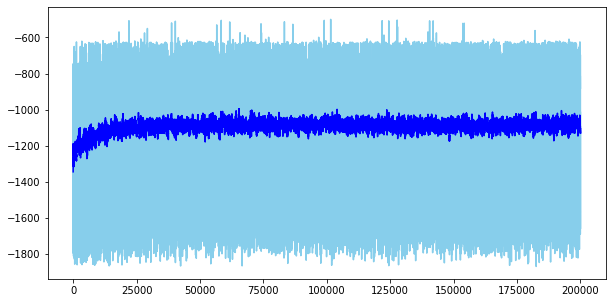

In [8]:
plt.figure(figsize=(10, 5))
average_returns = np.array(globalNet.average_returns[:])
ep_returns = np.array(globalNet.ep_returns[:])
nonzero_indices = average_returns!=0.0
plt.plot(ep_returns[nonzero_indices], color='skyblue')
plt.plot(average_returns[nonzero_indices], color='blue')
plt.show()
#fignum = len([f for f in os.listdir() if 'v3_Pendulum' in f and 'png' in f])
#plt.savefig('A3C_v3_Pendulum_%d.png'%fignum)

In [9]:
log_df.head()

,running,EP,Loss,Return,LR
